# STimage

In [3]:
import os; from os import listdir; import pandas as pd; import numpy as np; from numpy import asarray
import h5py; from pathlib import Path; import pickle; import tensorflow as tf; import copy; import warnings
import PIL; from PIL import Image; PIL.Image.MAX_IMAGE_PIXELS = 933120000


import shap; shap.initjs(); import lime; from lime import lime_image; import lime.lime_tabular
import stlearn; from tqdm import tqdm; import math
import plotly.express as px; import matplotlib.pyplot as plt; from matplotlib import cm as cm
import cv2; import joblib; from sklearn.metrics import confusion_matrix; import seaborn as sns

import tensorflow
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.applications import VGG16, ResNet50, inception_v3, DenseNet121
from tensorflow.keras.applications import imagenet_utils; from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image as load_img; from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input, Lambda
from tensorflow.keras.preprocessing import image as image_fun
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as pi;


from sklearn.preprocessing import LabelEncoder; from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score; from sklearn.preprocessing import LabelEncoder; from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier; from sklearn.multioutput import MultiOutputClassifier
import lightgbm as lgb; 


import scipy as sp; from scipy import ndimage as ndi; import time
from skimage.feature import peak_local_max; from skimage.segmentation import watershed; from skimage.measure import label
import skimage; from skimage.color import rgb2hed; from skimage.morphology import area_opening

# 10X

In [7]:
BASE_PATH = Path("D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img


SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

Sample1_un_norm, Sample2_un_norm = copy.copy(Sample1), copy.copy(Sample2)

for adata in [Sample1,Sample2,]:
    #Preprocessing
    st.pp.filter_genes(adata,min_cells=3)
    st.pp.log1p(adata)
    sc.pp.filter_cells(adata,min_counts=100)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    #tiling(adata, TILE_PATH_, crop_size=299)
    #st.pp.extract_feature(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X
Log transformation step is finished in adata.X


# FFPE

In [8]:
BASE_PATH = Path("D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "FFPE_Breast_Cancer"
Sample3 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"Visium_FFPE_Human_Breast_Cancer_image.tif", 0)
Sample3.uns["spatial"][SAMPLE]['images']["fulres"] = img


Sample3_un_norm = copy.copy(Sample3)
for adata in [Sample3,]:
     
    st.pp.filter_genes(adata,min_cells=3)
    sc.pp.filter_cells(adata,min_counts=100)
    st.pp.log1p(adata)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    #tiling(adata, TILE_PATH_, crop_size=299)
    #st.pp.extract_feature(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X


# 10X & FFPE

In [16]:
#Tile Paths of Filtered and Normalised Tiles

adata_obs = pd.read_csv("D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/pickle/adata.csv",index_col=0)
adata_obs.index = adata_obs.index.str[:-7]
Sample1_obs = adata_obs[adata_obs['library_id']=='block1'].sort_values("tile_path")
Sample1_obs['tile_path'] = Sample1_obs['tile_path'].str.split('/').str[10]
Sample2_obs = adata_obs[adata_obs['library_id']=='block2'].sort_values("tile_path")
Sample2_obs['tile_path'] = Sample2_obs['tile_path'].str.split('/').str[10]
Sample3_obs = pd.read_csv("D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/Sample3_obs.csv",index_col=0).sort_values("tile_path")
Sample3_obs['tile_path'] = Sample3_obs['tile_path'].str.split('\\').str[7]


model = ResNet50(weights='imagenet', pooling="avg", include_top = False) 

def ResNet50_features(files, pre_model):
 
    x_scratch_train = []
    for imagePath in files:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image) 
        x_scratch_train.append(image)
        
    x_train = np.vstack(x_scratch_train)
    features = pre_model.predict(x_train, batch_size=32)
    return features

norm_block1 = pd.DataFrame(ResNet50_features(Sample1_obs['tile_path'],model))
norm_block1.to_csv('D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/pickle/10X_Sample1A_norm.csv')

norm_block2 = pd.DataFrame(ResNet50_features(Sample2_obs['tile_path'],model))
norm_block2.to_csv('D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/pickle/10X_Sample2A_norm.csv')

norm_block3 = pd.DataFrame(ResNet50_features(Sample3_obs['tile_path'],model))
norm_block3.to_csv('D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/pickle/FFPE_Sample_norm.csv')

## Train

In [18]:
biomarker_list_2 = list(Sample3.to_df().mean().sort_values(ascending=False)[:100].index)
biomarker_list_2.remove('FGB')

model_c = MLPClassifier(max_iter=10000)
    
MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))
MinMax_scaler_y_2 = preprocessing.MinMaxScaler(feature_range =(0, 1))


Y_1 = Sample1.to_df()[biomarker_list_2]
Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
Y_1 = pd.DataFrame(data=Y_1)
Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
Y_1 = Y_1.astype('int64')


test_Y_1 = Sample3.to_df()[biomarker_list_2]
test_Y_1 = MinMax_scaler_y_2.fit_transform(test_Y_1)
test_Y_1 = pd.DataFrame(data=test_Y_1)
test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
test_Y_1 = test_Y_1.astype('int64')

In [33]:
import joblib; wd = "D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/pickle/"

norm_block1 = pd.read_csv(wd+'10X_Sample1A_norm.csv').iloc[:,1:]
norm_block3 = pd.read_csv(wd+'FFPE_Sample_norm.csv').iloc[:,1:] 

clf = MultiOutputClassifier(model_c).fit(X_train, Y_1)
joblib.dump(clf, wd+'FFPE_norm_Classification_MLP_Top100.pkl')

clf = joblib.load(wd+'FFPE_norm_Classification_MLP_Top100.pkl')
pred = clf.predict(norm_block3)

## AUROC & F1

C:\Users\ONKAR\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.0, 1.0)

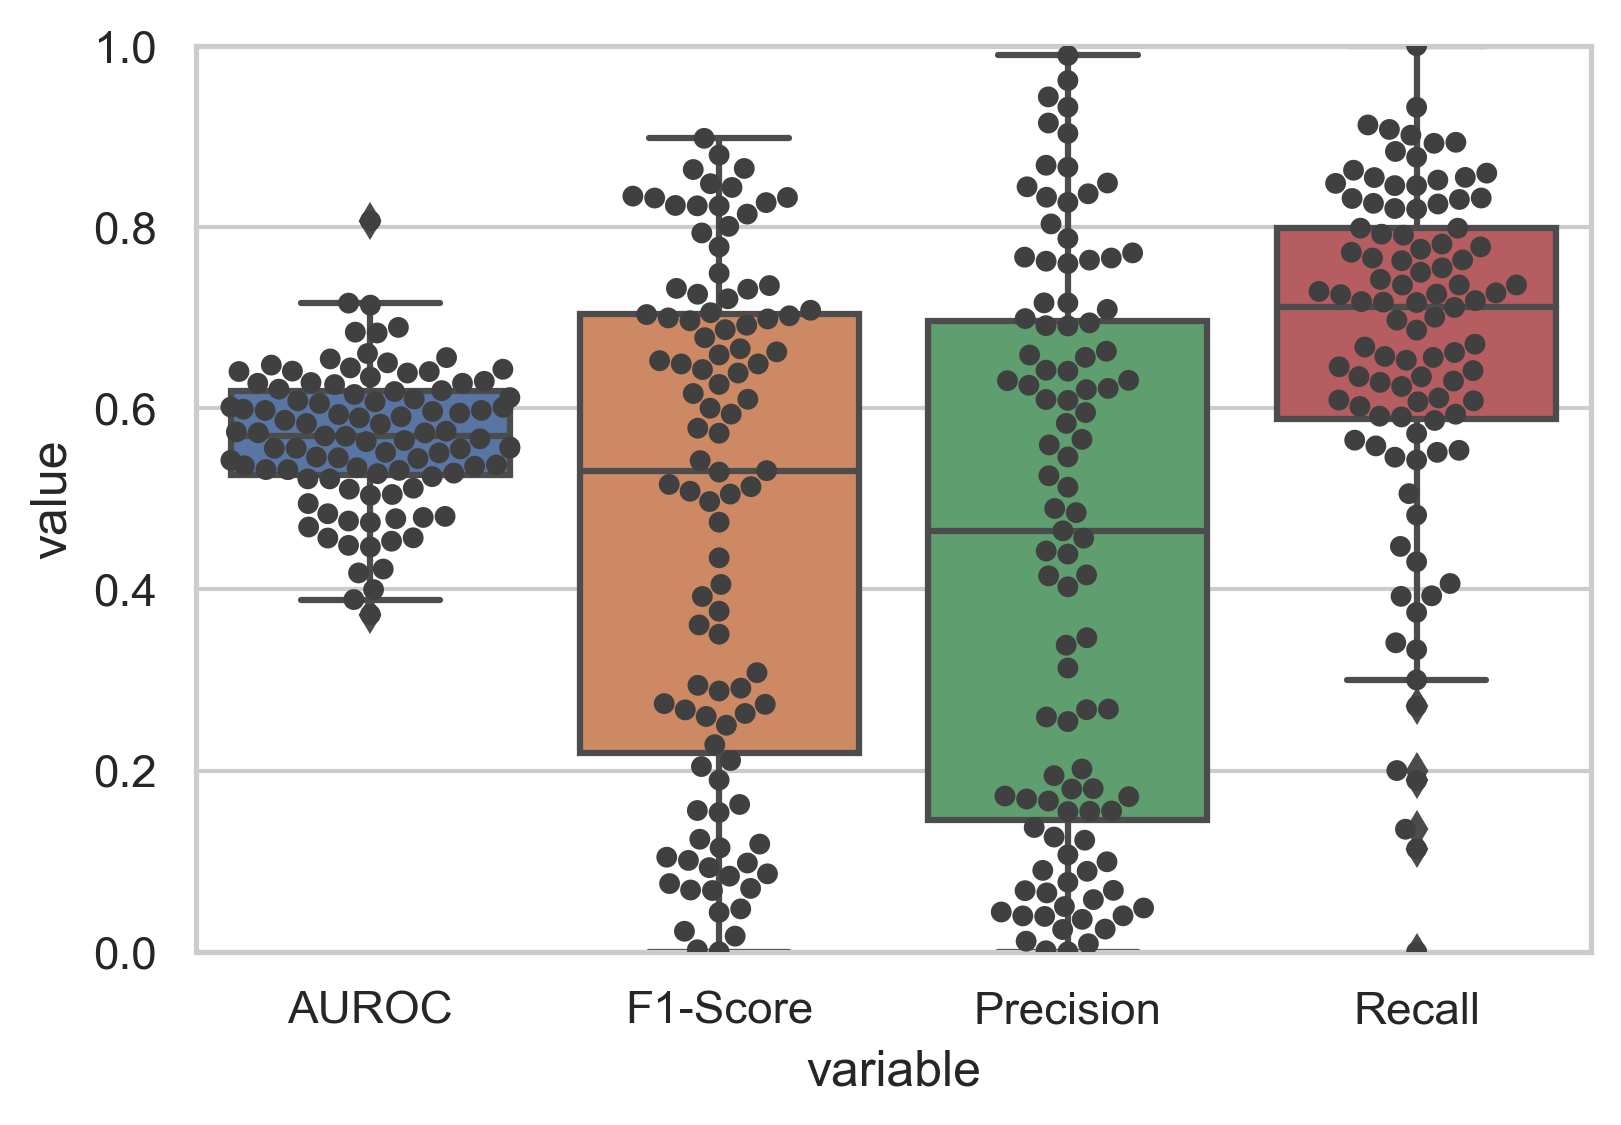

In [41]:
sns.set_theme(style="whitegrid")
sns.boxplot(x="variable", y="value",data=pd.melt(roc))
sns.swarmplot(x="variable", y="value",data=pd.melt(roc), color=".25")
plt.ylim(0, 1)
#plt.savefig(wd+'10X_Norm_Top100.jpeg')

C:\Users\ONKAR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


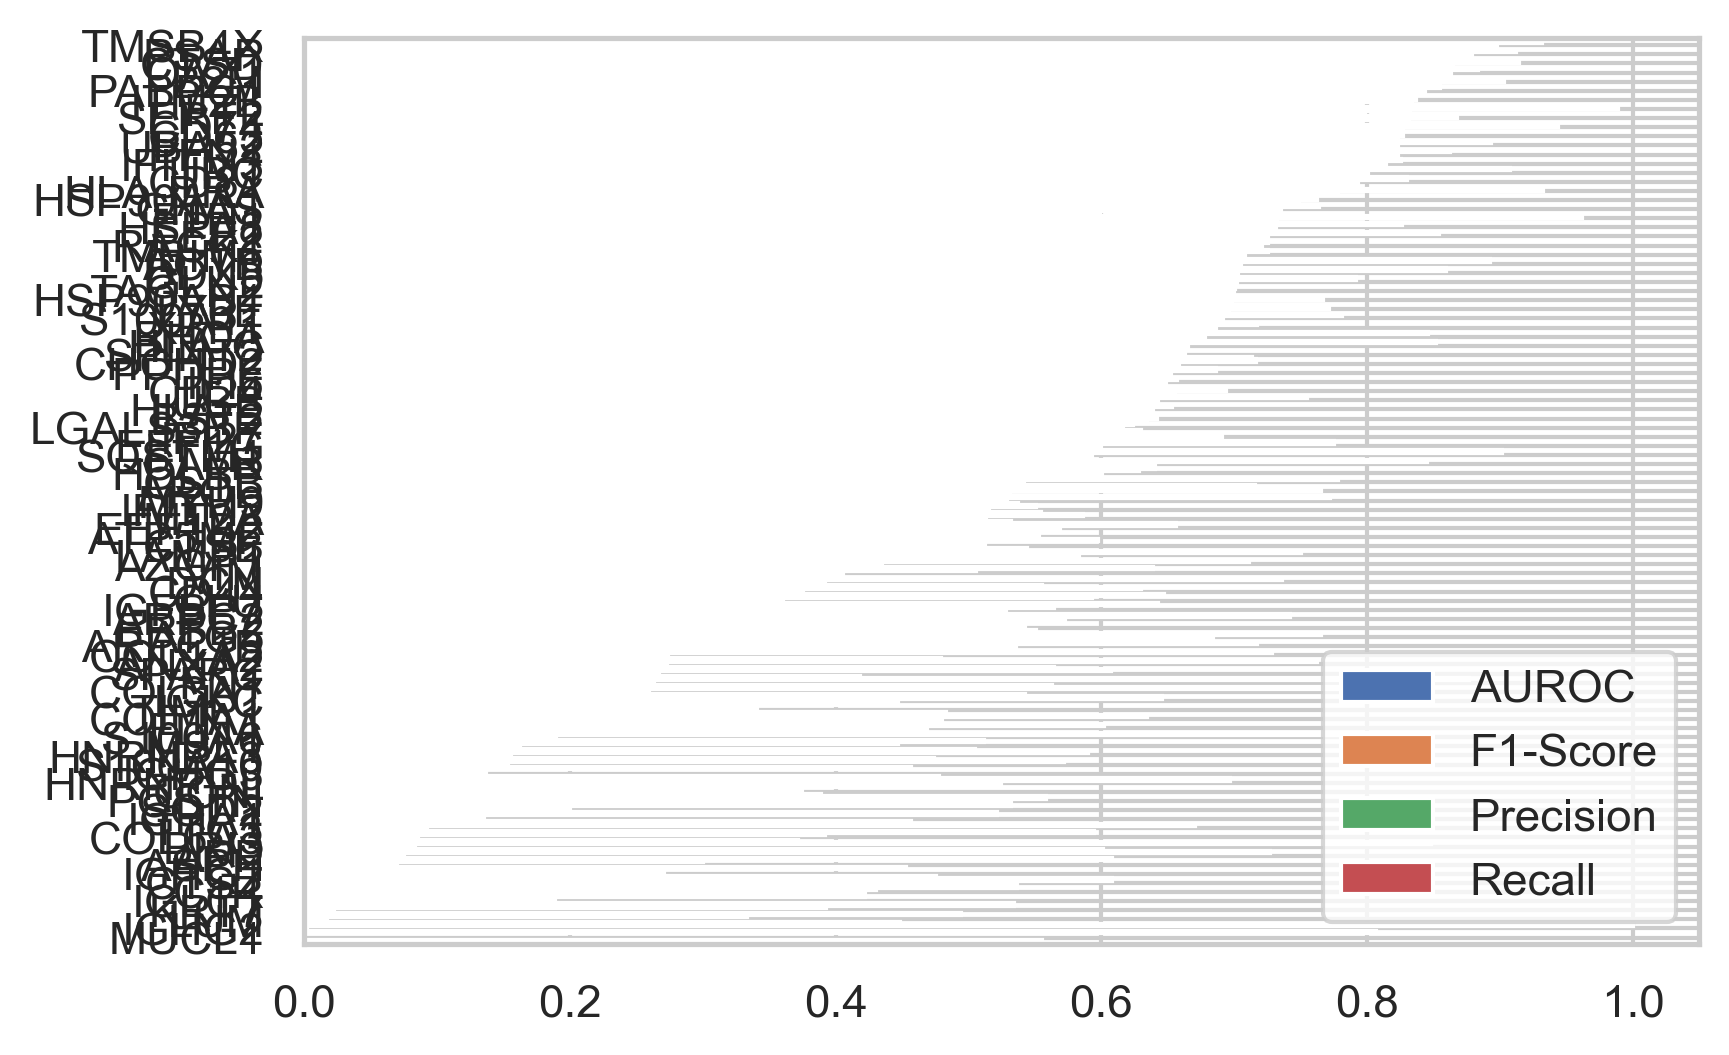

In [40]:
AUROC = []
for i in range(len(pred[0])):
    try:
        score = roc_auc_score(pred[:,i], test_Y_1.iloc[:,i])
        
    except:
        pass
    AUROC.append(score)
    
F1 = []
for i in range(len(pred[0])):
    score = f1_score(pred[:,i], test_Y_1.iloc[:,i], average='binary')
    F1.append(score)   

Precision = []
for i in range(len(pred[0])):
    score = precision_score(pred[:,i], test_Y_1.iloc[:,i], average='binary')
    Precision.append(score)   
    
Recall = []
for i in range(len(pred[0])):
    score = recall_score(pred[:,i], test_Y_1.iloc[:,i], average='binary')
    Recall.append(score)   
    

roc = pd.DataFrame(index = biomarker_list_2)
roc["AUROC"] = AUROC
roc["F1-Score"] = F1
roc["Precision"] = Precision
roc["Recall"] = Recall

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
ax = roc.sort_values(["F1-Score"]).plot(kind='barh', width=1.0, edgecolor='white')# figsize=(10,7.5), , color={'AUROC': '#357EC7', 'F1-Score': '#C2DFFF'})
fig = ax.get_figure()
#fig.savefig(wd+'FFPE_Classification_barplot_1650.jpeg')